In [143]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import get_dummies
from pandas import DataFrame
from numpy import nan
from pandas import to_datetime
# Show all columns
pd.set_option('display.max_columns', None)

In [144]:
# Import banking data
# Note: This data was extracted on 1999

# Each record describes characteristics of a client
client = pd.read_csv('./data/raw/data_berka/client.asc', sep=';')

# Each record describes static characteristics of an account
account = pd.read_csv('./data/raw/data_berka/account.asc', sep=';')

# Each record describes a credit card issued to an account
card = pd.read_csv('./data/raw/data_berka/card.asc', sep=';')

# Each record describes demographic characteristics of a district
district = pd.read_csv('./data/raw/data_berka/district.asc', sep=';')

# Each record relates together a client with an account
# i.e. this relation describes the rights of clients to operate accounts
disp = pd.read_csv('./data/raw/data_berka/disp.asc', sep=';')

# Each record describes characteristics of a payment order (debits only)
order = pd.read_csv('./data/raw/data_berka/order.asc', sep=';')

# Each record describes one transaction on an account
trans = pd.read_csv('./data/raw/data_berka/trans.asc', sep=';', low_memory=False)

# Each record describes a loan granted for a given account
loan = pd.read_csv('./data/raw/data_berka/loan.asc', sep=';')

In [145]:
#filter just the accounts from 1996
account['year'] = account['date'].astype(str).str[:2].astype(int) + 1900
df = account[account['year'] < 1996].copy(deep=True)
df.tail()

,account_id,district_id,frequency,date,year
2234,4462,73,POPLATEK TYDNE,951227,1995
2235,3814,74,POPLATEK MESICNE,951227,1995
2236,2780,63,POPLATEK MESICNE,951229,1995
2237,3273,74,POPLATEK MESICNE,951229,1995
2238,3559,18,POPLATEK MESICNE,951230,1995


In [146]:
df['lor'] = 1996 - df['year']
df.tail()

,account_id,district_id,frequency,date,year,lor
2234,4462,73,POPLATEK TYDNE,951227,1995,1
2235,3814,74,POPLATEK MESICNE,951227,1995,1
2236,2780,63,POPLATEK MESICNE,951229,1995,1
2237,3273,74,POPLATEK MESICNE,951229,1995,1
2238,3559,18,POPLATEK MESICNE,951230,1995,1


In [147]:
df = pd.merge(df, disp[disp['type'] == 'OWNER'], how='left', on='account_id')
df = pd.merge(df, client, how='left', on='client_id')
df = df.rename(columns={'district_id_x':'bank_district_id',
                        'district_id_y':'client_district_id'})
df.head()

,account_id,bank_district_id,frequency,date,year,lor,disp_id,client_id,type,birth_number,client_district_id
0,576,55,POPLATEK MESICNE,930101,1993,3,692,692,OWNER,365111,74
1,3818,74,POPLATEK MESICNE,930101,1993,3,4601,4601,OWNER,350402,1
2,704,55,POPLATEK MESICNE,930101,1993,3,844,844,OWNER,450114,22
3,2378,16,POPLATEK MESICNE,930101,1993,3,2873,2873,OWNER,755324,16
4,2632,24,POPLATEK MESICNE,930102,1993,3,3177,3177,OWNER,380812,24


In [148]:
# Transform the birth day into year
df['birth_year'] = '19' + df['birth_number'].astype(str).str[:2]
df['birth_year'] = df['birth_year'].astype(int)

# Transform the birth day to day
df['birth_day'] = df['birth_number'].astype(str).str[-2:].astype(int)

# Extract the birth month
df['birth_month'] = df['birth_number'].astype(str).str[2:4].astype(int)

# Extract and correct the gender
df['gender'] = 'M'
df.loc[df['birth_month'] > 50, 'gender'] = 'F'

# Correct the birth month
df.loc[df['birth_month'] > 50, 'birth_month'] = df.loc[df['birth_month'] > 50, 'birth_month'] - 50
df.head()

,account_id,bank_district_id,frequency,date,year,lor,disp_id,client_id,type,birth_number,client_district_id,birth_year,birth_day,birth_month,gender
0,576,55,POPLATEK MESICNE,930101,1993,3,692,692,OWNER,365111,74,1936,11,1,F
1,3818,74,POPLATEK MESICNE,930101,1993,3,4601,4601,OWNER,350402,1,1935,2,4,M
2,704,55,POPLATEK MESICNE,930101,1993,3,844,844,OWNER,450114,22,1945,14,1,M
3,2378,16,POPLATEK MESICNE,930101,1993,3,2873,2873,OWNER,755324,16,1975,24,3,F
4,2632,24,POPLATEK MESICNE,930102,1993,3,3177,3177,OWNER,380812,24,1938,12,8,M


In [149]:
# Age
df['age'] = 1996 - df['birth_year']

# Age group
df['age_group'] = df['age'] // 10 * 10
df.describe()

,account_id,bank_district_id,date,year,lor,disp_id,client_id,birth_number,client_district_id,birth_year,birth_day,birth_month,age,age_group
count,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000
mean,2812.454667,37.748548,938538.620366,1993.786512,2.213488,3391.035730,3413.595802,542521.089326,37.736936,1953.943278,15.685127,6.518982,42.056722,37.405092
std,2346.517861,25.236180,8722.757846,0.871029,0.871029,2817.262235,2880.044705,171213.422446,24.994173,17.102929,8.831736,3.434107,17.102929,17.354316
min,1.000000,1.000000,930101.000000,1993.000000,1.000000,1.000000,1.000000,180111.000000,1.000000,1918.000000,1.000000,1.000000,14.000000,10.000000
25%,1158.500000,14.000000,930702.000000,1993.000000,1.000000,1393.000000,1393.000000,415912.000000,15.000000,1941.000000,8.000000,4.000000,27.000000,20.000000
50%,2379.000000,39.000000,931223.000000,1993.000000,3.000000,2874.000000,2874.000000,550210.000000,39.000000,1955.000000,16.000000,7.000000,41.000000,40.000000
75%,3606.000000,61.000000,950223.000000,1995.000000,3.000000,4349.500000,4349.500000,690862.500000,60.000000,1969.000000,24.000000,9.000000,55.000000,50.000000
max,11382.000000,77.000000,951230.000000,1995.000000,3.000000,13690.000000,13998.000000,826211.000000,77.000000,1982.000000,31.000000,12.000000,78.000000,70.000000


In [150]:
trans96k = trans[trans['date'].astype(str).str[:2].isin(['96'])]

In [151]:
transtype = pd.DataFrame()
transtype['household_total'] = trans96k[trans96k['k_symbol'] == 'SIPO'].groupby("account_id")['amount'].sum()
transtype['insurance_total'] = trans96k[trans96k['k_symbol'] == 'POJISTNE'].groupby("account_id")['amount'].sum()
transtype['payment_total'] = trans96k[trans96k['k_symbol'] == 'SLUZBY'].groupby("account_id")['amount'].sum()
transtype['loan_total'] = trans96k[trans96k['k_symbol'] == 'UVER'].groupby("account_id")['amount'].sum()
transtype['sanctionint_total'] = trans96k[trans96k['k_symbol'] == 'SANKC. UROK'].groupby("account_id")['amount'].sum()

transtype = transtype.fillna(0)
transtype.reset_index(drop=True)
transtype

,household_total,insurance_total,payment_total,loan_total,sanctionint_total
account_id,,,,,
1,29424.0,0.0,175.2,0.0,0.0
2,87192.0,0.0,175.2,0.0,0.0
4,10390.0,0.0,87.6,0.0,0.0
6,47448.0,0.0,175.2,0.0,0.0
8,28732.0,0.0,160.6,0.0,0.0
...,...,...,...,...,...
11271,63888.0,5676.0,160.6,0.0,0.0
11295,80400.0,0.0,175.2,0.0,0.0
11349,130632.0,0.0,360.0,83976.0,0.0


In [152]:
df = pd.merge(df, transtype, how='left', on='account_id').reset_index(drop=True)
df

,account_id,bank_district_id,frequency,date,year,lor,disp_id,client_id,type,birth_number,client_district_id,birth_year,birth_day,birth_month,gender,age,age_group,household_total,insurance_total,payment_total,loan_total,sanctionint_total
0,576,55,POPLATEK MESICNE,930101,1993,3,692,692,OWNER,365111,74,1936,11,1,F,60,60,43944.0,0.0,175.2,0.0,0.0
1,3818,74,POPLATEK MESICNE,930101,1993,3,4601,4601,OWNER,350402,1,1935,2,4,M,61,60,43152.0,48780.0,175.2,0.0,0.0
2,704,55,POPLATEK MESICNE,930101,1993,3,844,844,OWNER,450114,22,1945,14,1,M,51,50,25692.0,0.0,175.2,0.0,0.0
3,2378,16,POPLATEK MESICNE,930101,1993,3,2873,2873,OWNER,755324,16,1975,24,3,F,21,20,115344.0,0.0,175.2,0.0,0.0
4,2632,24,POPLATEK MESICNE,930102,1993,3,3177,3177,OWNER,380812,24,1938,12,8,M,58,50,24504.0,27600.0,175.2,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2234,4462,73,POPLATEK TYDNE,951227,1995,1,5384,5384,OWNER,350721,73,1935,21,7,M,61,60,NaN,NaN,NaN,NaN,NaN
2235,3814,74,POPLATEK MESICNE,951227,1995,1,4596,4596,OWNER,735831,74,1973,31,8,F,23,20,NaN,NaN,NaN,NaN,NaN
2236,2780,63,POPLATEK MESICNE,951229,1995,1,3357,3357,OWNER,545721,63,1954,21,7,F,42,40,NaN,NaN,NaN,NaN,NaN
2237,3273,74,POPLATEK MESICNE,951229,1995,1,3962,3962,OWNER,521128,74,1952,28,11,M,44,40,NaN,NaN,NaN,NaN,NaN


In [153]:
trans96 = trans[trans['date'].astype(str).str[:2].isin(['96'])]

In [154]:
# Aggregate the total credit per account
trans_agg_credit = trans96[trans96['type'].isin(['PRIJEM'])].groupby('account_id')['amount'].agg('sum')
trans_agg_credit = trans_agg_credit.reset_index()
trans_agg_credit = trans_agg_credit.rename(columns={'amount':'total_credit'})
trans_agg_credit.head()

,account_id,total_credit
0,1,50066.0
1,2,288542.9
2,4,56920.5
3,6,81507.7
4,7,34905.4


In [155]:
# Aggregate the total withdrawal per account
trans_agg_withdrawal = trans96[trans96['type'].isin(['VYDAJ'])].groupby('account_id')['amount'].agg('sum')
trans_agg_withdrawal = trans_agg_withdrawal.reset_index()
trans_agg_withdrawal = trans_agg_withdrawal.rename(columns={'amount':'total_withdrawal'})
trans_agg_withdrawal.head()

,account_id,total_withdrawal
0,1,55579.2
1,2,202067.2
2,4,31977.6
3,6,81803.2
4,7,6600.0


In [156]:
# Join with previous table
df = pd.merge(df, trans_agg_credit, how='left', on='account_id').reset_index(drop=True)
df = pd.merge(df, trans_agg_withdrawal, how='left', on='account_id').reset_index(drop=True)
df.describe()

,account_id,bank_district_id,date,year,lor,disp_id,client_id,birth_number,client_district_id,birth_year,birth_day,birth_month,age,age_group,household_total,insurance_total,payment_total,loan_total,sanctionint_total,total_credit,total_withdrawal
count,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,2239.000000,1636.000000,1636.000000,1636.000000,1636.000000,1636.000000,2.238000e+03,2239.000000
mean,2812.454667,37.748548,938538.620366,1993.786512,2.213488,3391.035730,3413.595802,542521.089326,37.736936,1953.943278,15.685127,6.518982,42.056722,37.405092,48711.151589,2394.584352,193.189609,3763.455685,0.872555,2.044362e+05,188840.286958
std,2346.517861,25.236180,8722.757846,0.871029,0.871029,2817.262235,2880.044705,171213.422446,24.994173,17.102929,8.831736,3.434107,17.102929,17.354316,33832.768948,9951.941043,121.593909,13842.132692,12.939489,1.734424e+05,152962.080247
min,1.000000,1.000000,930101.000000,1993.000000,1.000000,1.000000,1.000000,180111.000000,1.000000,1918.000000,1.000000,1.000000,14.000000,10.000000,24.000000,0.000000,29.200000,0.000000,0.000000,2.956000e+02,900.000000
25%,1158.500000,14.000000,930702.000000,1993.000000,1.000000,1393.000000,1393.000000,415912.000000,15.000000,1941.000000,8.000000,4.000000,27.000000,20.000000,25160.500000,0.000000,175.200000,0.000000,0.000000,7.161920e+04,69639.200000
50%,2379.000000,39.000000,931223.000000,1993.000000,3.000000,2874.000000,2874.000000,550210.000000,39.000000,1955.000000,16.000000,7.000000,41.000000,40.000000,39120.000000,0.000000,175.200000,0.000000,0.000000,1.582491e+05,150442.800000
75%,3606.000000,61.000000,950223.000000,1995.000000,3.000000,4349.500000,4349.500000,690862.500000,60.000000,1969.000000,24.000000,9.000000,55.000000,50.000000,67347.000000,0.000000,175.200000,0.000000,0.000000,2.757074e+05,266867.200000
max,11382.000000,77.000000,951230.000000,1995.000000,3.000000,13690.000000,13998.000000,826211.000000,77.000000,1982.000000,31.000000,12.000000,78.000000,70.000000,195400.000000,112536.000000,1200.000000,116268.000000,454.500000,1.040785e+06,982712.200000


Debo unir las cuentas hasta 1997 con loans pedidos en solo en 1997 (debo sacar las cuentas creadas hasta 1996? o las anteriores)
crear una variable 1 tiene loan id 2 tiene missing value en loan

In [157]:
trans96_recency = trans96.groupby("account_id")["date"].agg(["max", "count"]).reset_index()
trans96_recency['recency'] = (pd.to_datetime('96.12.31', format='%y.%m.%d') - pd.to_datetime(trans96_recency['max'], format='%y%m%d')).dt.days
trans96_recency = trans96_recency.rename(columns={'count':'frequency'})
trans96_recency.drop(columns='max')

,account_id,frequency,recency
0,1,74,0
1,2,85,0
2,4,39,0
3,6,63,0
4,7,4,0
...,...,...,...
3597,11333,88,0
3598,11349,88,0
3599,11359,95,0
3600,11362,102,0


In [158]:
trans96_monetary = trans96.groupby("account_id")["amount"].agg("sum").reset_index()
trans96_monetary = trans96_monetary.rename(columns={'amount':'monetary'})
trans96_monetary

,account_id,monetary
0,1,105645.2
1,2,563117.1
2,4,88898.1
3,6,163310.9
4,7,41505.4
...,...,...
3597,11333,833929.9
3598,11349,1093960.3
3599,11359,704593.7
3600,11362,433577.6


In [159]:
df = pd.merge(df, trans96_recency, how='left', on='account_id').reset_index(drop=True)
df = pd.merge(df, trans96_monetary, how='left', on='account_id').reset_index(drop=True)
df

,account_id,bank_district_id,frequency_x,date,year,lor,disp_id,client_id,type,birth_number,client_district_id,birth_year,birth_day,birth_month,gender,age,age_group,household_total,insurance_total,payment_total,loan_total,sanctionint_total,total_credit,total_withdrawal,max,frequency_y,recency,monetary
0,576,55,POPLATEK MESICNE,930101,1993,3,692,692,OWNER,365111,74,1936,11,1,F,60,60,43944.0,0.0,175.2,0.0,0.0,76097.3,70419.2,961231,62,0,146516.5
1,3818,74,POPLATEK MESICNE,930101,1993,3,4601,4601,OWNER,350402,1,1935,2,4,M,61,60,43152.0,48780.0,175.2,0.0,0.0,234806.4,223535.2,961231,98,0,458341.6
2,704,55,POPLATEK MESICNE,930101,1993,3,844,844,OWNER,450114,22,1945,14,1,M,51,50,25692.0,0.0,175.2,0.0,0.0,228514.9,218531.2,961231,84,0,447046.1
3,2378,16,POPLATEK MESICNE,930101,1993,3,2873,2873,OWNER,755324,16,1975,24,3,F,21,20,115344.0,0.0,175.2,0.0,0.0,664545.4,621619.2,961231,83,0,1297855.6
4,2632,24,POPLATEK MESICNE,930102,1993,3,3177,3177,OWNER,380812,24,1938,12,8,M,58,50,24504.0,27600.0,175.2,0.0,0.0,186658.9,191071.2,961231,98,0,377730.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2234,4462,73,POPLATEK TYDNE,951227,1995,1,5384,5384,OWNER,350721,73,1935,21,7,M,61,60,NaN,NaN,NaN,NaN,NaN,210483.6,135031.5,961231,48,0,397920.1
2235,3814,74,POPLATEK MESICNE,951227,1995,1,4596,4596,OWNER,735831,74,1973,31,8,F,23,20,NaN,NaN,NaN,NaN,NaN,29400.0,3000.0,961221,12,10,32400.0
2236,2780,63,POPLATEK MESICNE,951229,1995,1,3357,3357,OWNER,545721,63,1954,21,7,F,42,40,NaN,NaN,NaN,NaN,NaN,187419.5,154916.8,961231,50,0,342336.3
2237,3273,74,POPLATEK MESICNE,951229,1995,1,3962,3962,OWNER,521128,74,1952,28,11,M,44,40,NaN,NaN,NaN,NaN,NaN,655807.8,606916.8,961231,72,0,1267017.6


In [160]:
loan97 = loan[loan['date'].astype(str).str[:2].isin(['97'])]
loan97.tail()


,loan_id,account_id,date,amount,duration,payments,status
519,6059,5196,971228,79824,12,6652.0,A
520,5799,4052,971228,106128,36,2948.0,C
521,6147,5602,971228,177504,48,3698.0,C
522,6254,6157,971228,247920,48,5165.0,C
523,7100,10280,971231,348120,60,5802.0,C


In [161]:
loan97['DV'] = 1
loan97 = loan97[['account_id', 'DV']]
loan97.head()

C:\Users\cmurciaromero1\AppData\Local\Temp\ipykernel_1732\4292017079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan97['DV'] = 1


,account_id,DV
328,4473,1
329,10365,1
330,5724,1
331,5591,1
332,2018,1


In [162]:
df = pd.merge(df, loan97, how='left', on='account_id')

In [163]:
df.info()
df['DV'].isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2239 entries, 0 to 2238
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   account_id          2239 non-null   int64  
 1   bank_district_id    2239 non-null   int64  
 2   frequency_x         2239 non-null   object 
 3   date                2239 non-null   int64  
 4   year                2239 non-null   int32  
 5   lor                 2239 non-null   int32  
 6   disp_id             2239 non-null   int64  
 7   client_id           2239 non-null   int64  
 8   type                2239 non-null   object 
 9   birth_number        2239 non-null   int64  
 10  client_district_id  2239 non-null   int64  
 11  birth_year          2239 non-null   int32  
 12  birth_day           2239 non-null   int32  
 13  birth_month         2239 non-null   int32  
 14  gender              2239 non-null   object 
 15  age                 2239 non-null   int32  
 16  age_gr

2208

In [164]:
df['DV'] = df['DV'].fillna(0)
df.head()

,account_id,bank_district_id,frequency_x,date,year,lor,disp_id,client_id,type,birth_number,client_district_id,birth_year,birth_day,birth_month,gender,age,age_group,household_total,insurance_total,payment_total,loan_total,sanctionint_total,total_credit,total_withdrawal,max,frequency_y,recency,monetary,DV
0,576,55,POPLATEK MESICNE,930101,1993,3,692,692,OWNER,365111,74,1936,11,1,F,60,60,43944.0,0.0,175.2,0.0,0.0,76097.3,70419.2,961231,62,0,146516.5,0.0
1,3818,74,POPLATEK MESICNE,930101,1993,3,4601,4601,OWNER,350402,1,1935,2,4,M,61,60,43152.0,48780.0,175.2,0.0,0.0,234806.4,223535.2,961231,98,0,458341.6,0.0
2,704,55,POPLATEK MESICNE,930101,1993,3,844,844,OWNER,450114,22,1945,14,1,M,51,50,25692.0,0.0,175.2,0.0,0.0,228514.9,218531.2,961231,84,0,447046.1,0.0
3,2378,16,POPLATEK MESICNE,930101,1993,3,2873,2873,OWNER,755324,16,1975,24,3,F,21,20,115344.0,0.0,175.2,0.0,0.0,664545.4,621619.2,961231,83,0,1297855.6,0.0
4,2632,24,POPLATEK MESICNE,930102,1993,3,3177,3177,OWNER,380812,24,1938,12,8,M,58,50,24504.0,27600.0,175.2,0.0,0.0,186658.9,191071.2,961231,98,0,377730.1,0.0


In [165]:
cardissue97 = card[card['issued'].astype(str).str[:2].isin(['97'])]
cardissue97.tail()

,card_id,disp_id,type,issued
438,566,3606,classic,971225 00:00:00
439,575,3667,gold,971225 00:00:00
440,154,887,classic,971228 00:00:00
441,130,722,classic,971229 00:00:00
442,434,2739,classic,971230 00:00:00


In [166]:
cardissue97['DV2'] = 1
cardissue97 = cardissue97[['disp_id', 'DV2']]
cardissue97.head()

C:\Users\cmurciaromero1\AppData\Local\Temp\ipykernel_1732\446291776.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cardissue97['DV2'] = 1


,disp_id,DV2
201,11393,1
202,1040,1
203,3601,1
204,4638,1
205,786,1


In [167]:
df = pd.merge(df, cardissue97, how='left', on='disp_id')

In [168]:
df['DV2'] = df['DV2'].fillna(0)
df.head()

,account_id,bank_district_id,frequency_x,date,year,lor,disp_id,client_id,type,birth_number,client_district_id,birth_year,birth_day,birth_month,gender,age,age_group,household_total,insurance_total,payment_total,loan_total,sanctionint_total,total_credit,total_withdrawal,max,frequency_y,recency,monetary,DV,DV2
0,576,55,POPLATEK MESICNE,930101,1993,3,692,692,OWNER,365111,74,1936,11,1,F,60,60,43944.0,0.0,175.2,0.0,0.0,76097.3,70419.2,961231,62,0,146516.5,0.0,0.0
1,3818,74,POPLATEK MESICNE,930101,1993,3,4601,4601,OWNER,350402,1,1935,2,4,M,61,60,43152.0,48780.0,175.2,0.0,0.0,234806.4,223535.2,961231,98,0,458341.6,0.0,0.0
2,704,55,POPLATEK MESICNE,930101,1993,3,844,844,OWNER,450114,22,1945,14,1,M,51,50,25692.0,0.0,175.2,0.0,0.0,228514.9,218531.2,961231,84,0,447046.1,0.0,0.0
3,2378,16,POPLATEK MESICNE,930101,1993,3,2873,2873,OWNER,755324,16,1975,24,3,F,21,20,115344.0,0.0,175.2,0.0,0.0,664545.4,621619.2,961231,83,0,1297855.6,0.0,0.0
4,2632,24,POPLATEK MESICNE,930102,1993,3,3177,3177,OWNER,380812,24,1938,12,8,M,58,50,24504.0,27600.0,175.2,0.0,0.0,186658.9,191071.2,961231,98,0,377730.1,0.0,0.0


In [169]:
dropcol = ['date', 'birth_number', 'max','type', 'frequency_x']
df = df.drop(columns=dropcol)
df

,account_id,bank_district_id,year,lor,disp_id,client_id,client_district_id,birth_year,birth_day,birth_month,gender,age,age_group,household_total,insurance_total,payment_total,loan_total,sanctionint_total,total_credit,total_withdrawal,frequency_y,recency,monetary,DV,DV2
0,576,55,1993,3,692,692,74,1936,11,1,F,60,60,43944.0,0.0,175.2,0.0,0.0,76097.3,70419.2,62,0,146516.5,0.0,0.0
1,3818,74,1993,3,4601,4601,1,1935,2,4,M,61,60,43152.0,48780.0,175.2,0.0,0.0,234806.4,223535.2,98,0,458341.6,0.0,0.0
2,704,55,1993,3,844,844,22,1945,14,1,M,51,50,25692.0,0.0,175.2,0.0,0.0,228514.9,218531.2,84,0,447046.1,0.0,0.0
3,2378,16,1993,3,2873,2873,16,1975,24,3,F,21,20,115344.0,0.0,175.2,0.0,0.0,664545.4,621619.2,83,0,1297855.6,0.0,0.0
4,2632,24,1993,3,3177,3177,24,1938,12,8,M,58,50,24504.0,27600.0,175.2,0.0,0.0,186658.9,191071.2,98,0,377730.1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2234,4462,73,1995,1,5384,5384,73,1935,21,7,M,61,60,NaN,NaN,NaN,NaN,NaN,210483.6,135031.5,48,0,397920.1,0.0,0.0
2235,3814,74,1995,1,4596,4596,74,1973,31,8,F,23,20,NaN,NaN,NaN,NaN,NaN,29400.0,3000.0,12,10,32400.0,0.0,0.0
2236,2780,63,1995,1,3357,3357,63,1954,21,7,F,42,40,NaN,NaN,NaN,NaN,NaN,187419.5,154916.8,50,0,342336.3,0.0,0.0
2237,3273,74,1995,1,3962,3962,74,1952,28,11,M,44,40,NaN,NaN,NaN,NaN,NaN,655807.8,606916.8,72,0,1267017.6,1.0,0.0


In [170]:
target_columns = ['account_id', 'bank_district_id', 'disp_id', 'client_id', 'client_district_id']
feature_columns = [col for col in df.columns if col not in target_columns]

# Initialize dictionaries for categorizing features
categorized_features = {'numerical': [], 'categorical': [], 'others': []}

# Categorize features based on their data types
for col in feature_columns:
    if df[col].dtype in ['int64', 'float64']:
        categorized_features['numerical'].append(col)
    elif df[col].dtype == 'object':
        categorized_features['categorical'].append(col)
    else:
        categorized_features['others'].append(col)

# Display the categorized features
print("Numerical Features:", categorized_features['numerical'])
print("Categorical Features:", categorized_features['categorical'])
print("Other Features:", categorized_features['others'])

Numerical Features: ['household_total', 'insurance_total', 'payment_total', 'loan_total', 'sanctionint_total', 'total_credit', 'total_withdrawal', 'frequency_y', 'recency', 'monetary', 'DV', 'DV2']
Categorical Features: ['gender']
Other Features: ['year', 'lor', 'birth_year', 'birth_day', 'birth_month', 'age', 'age_group']


Plotting for Numerical Features...


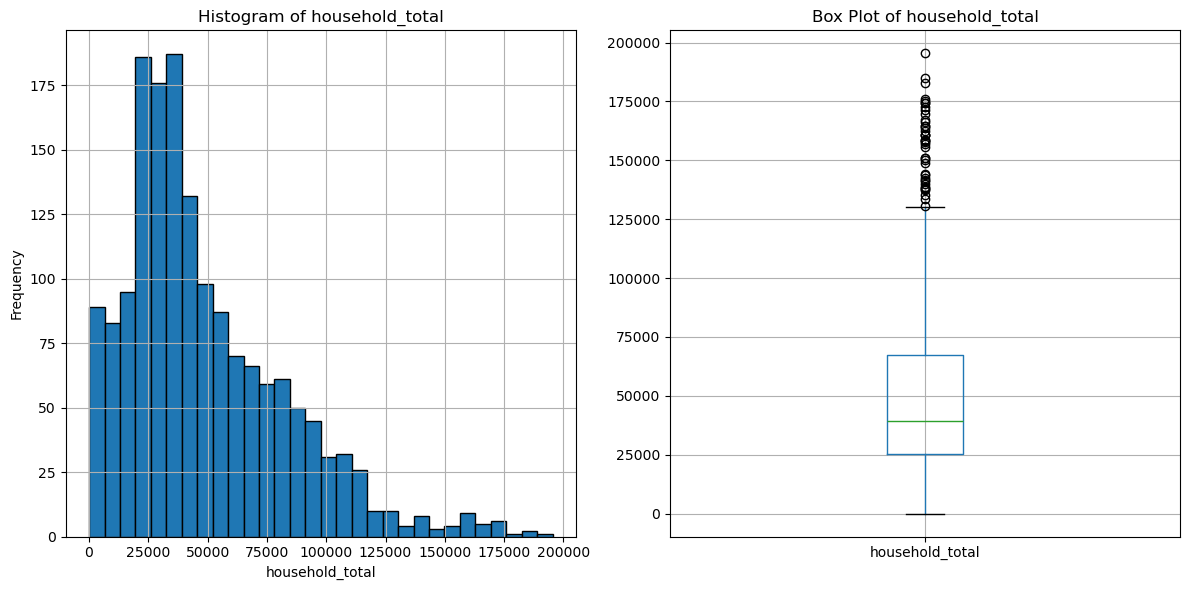

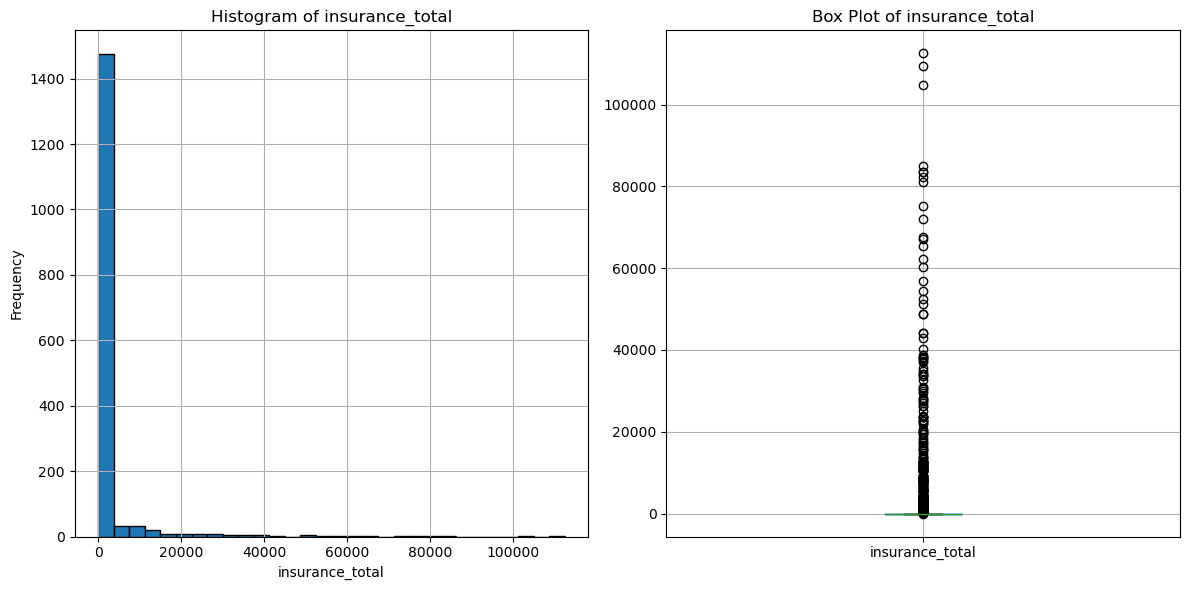

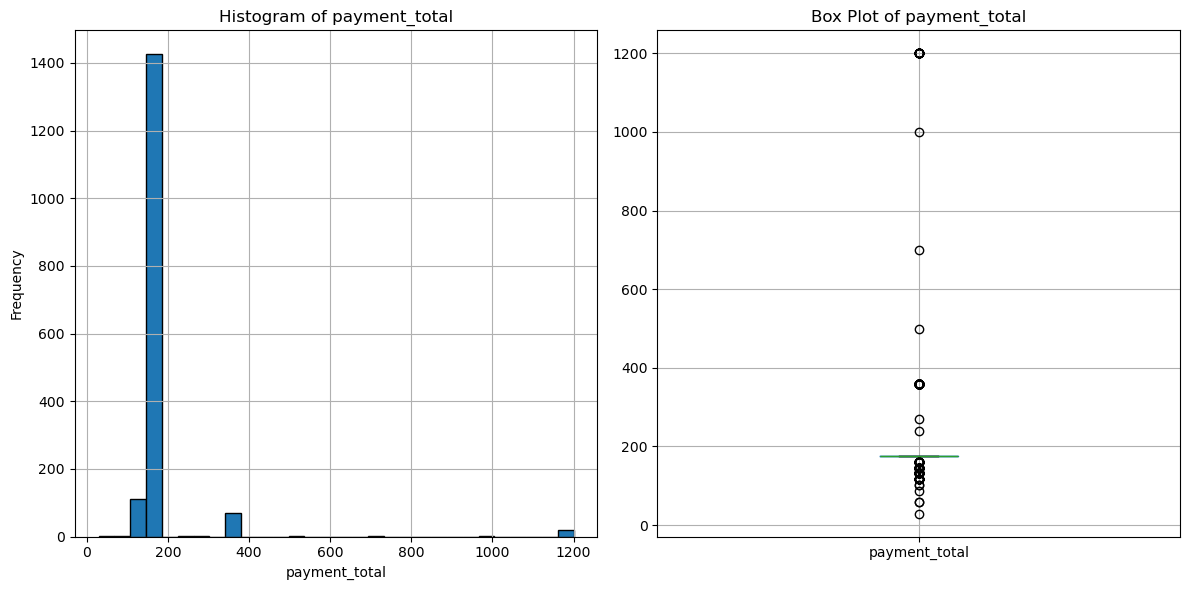

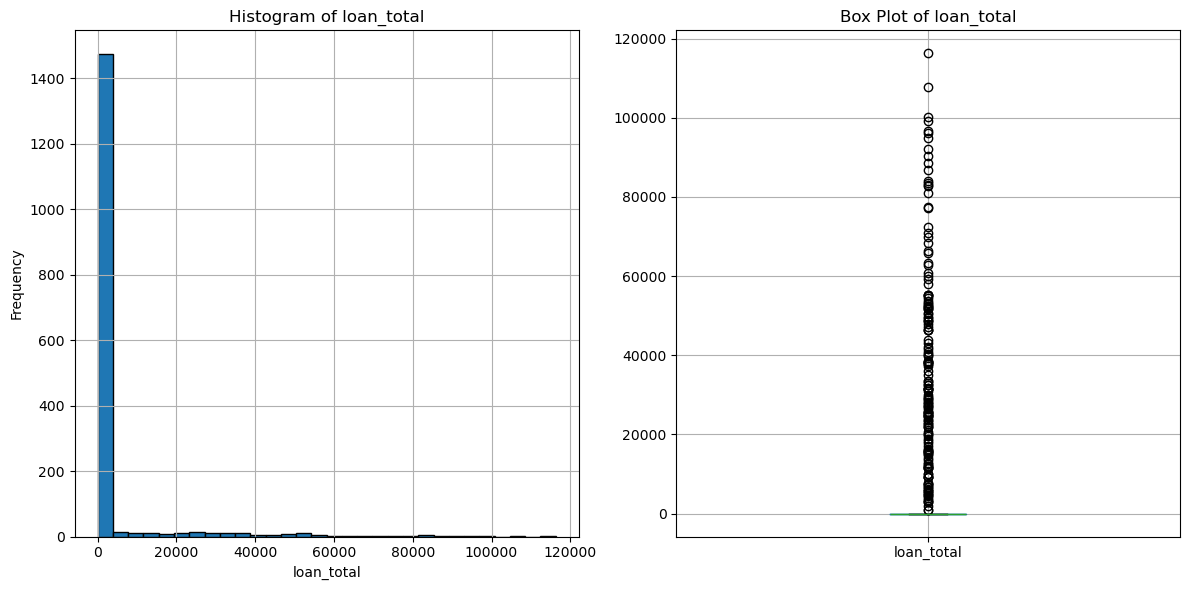

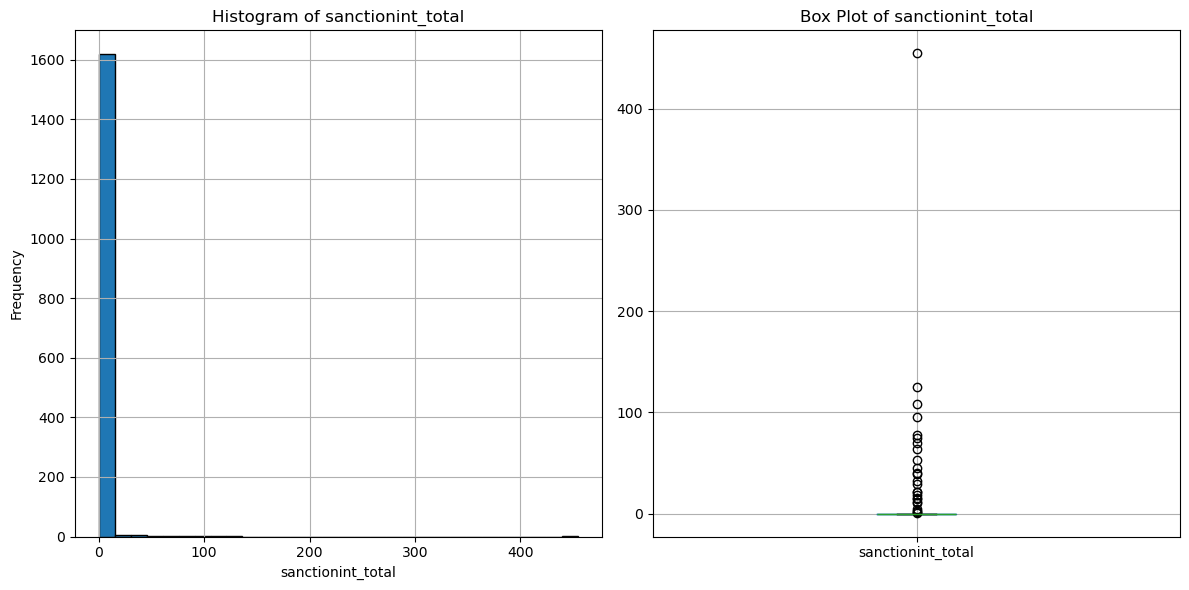

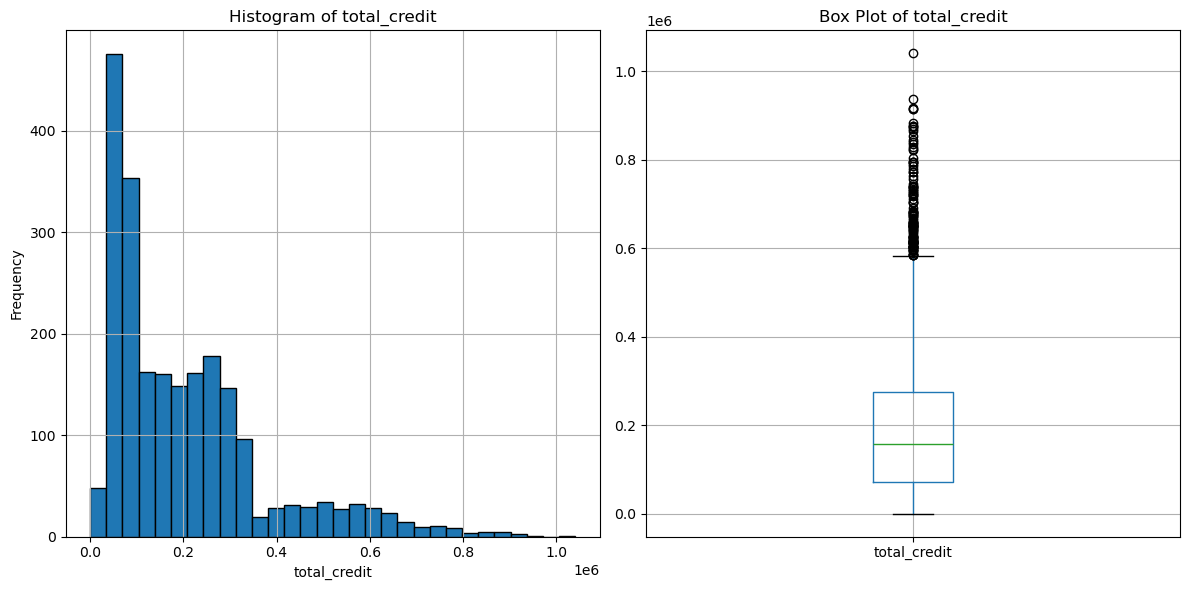

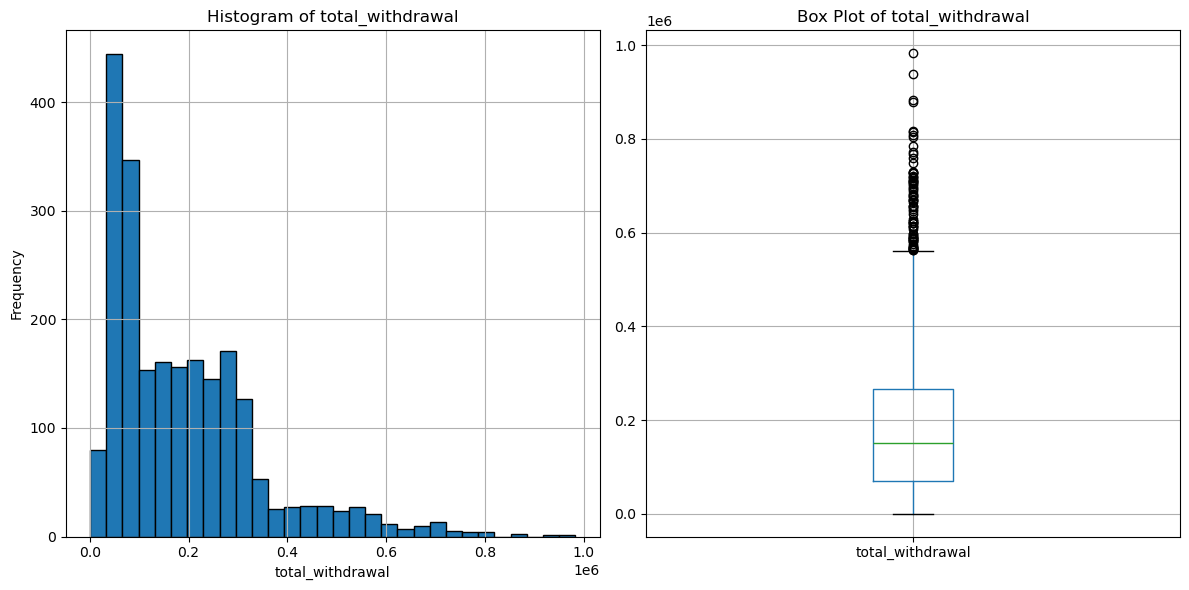

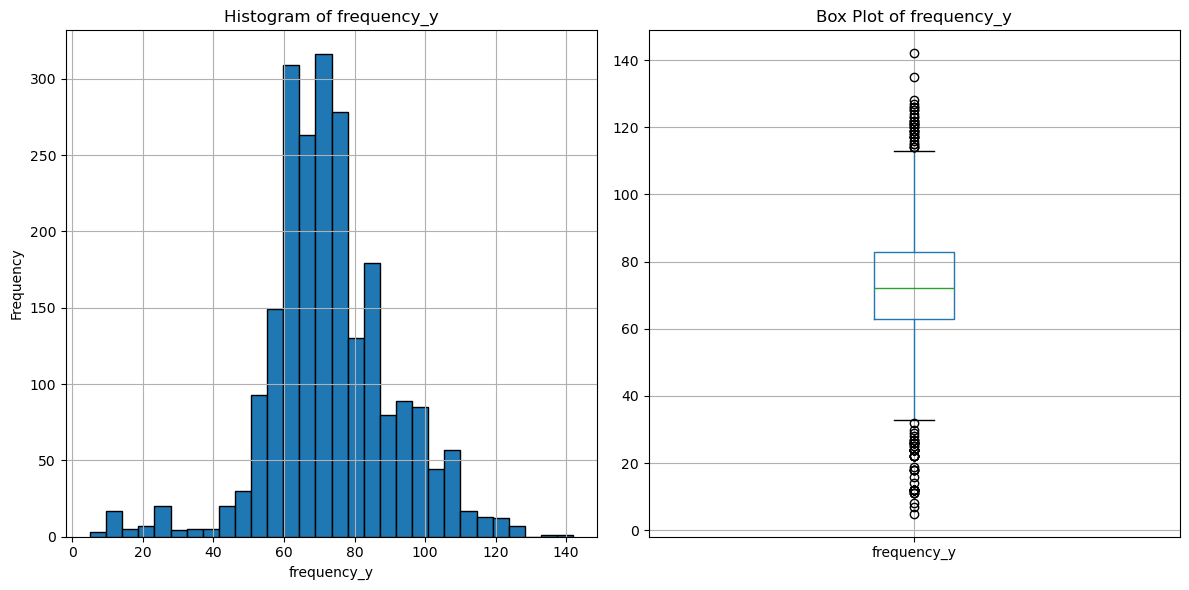

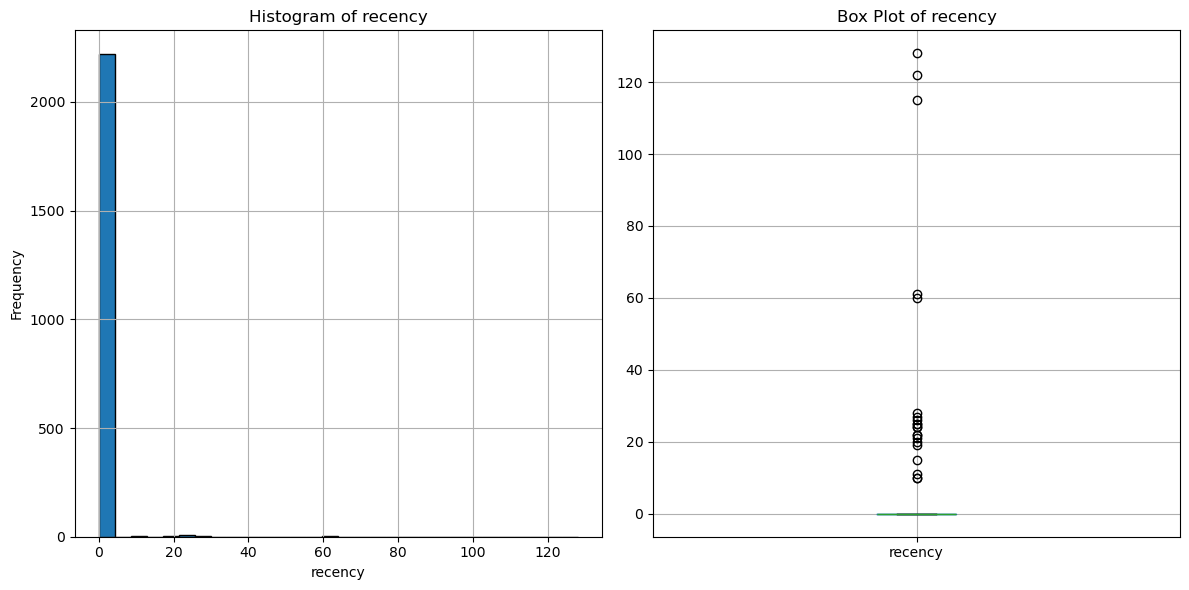

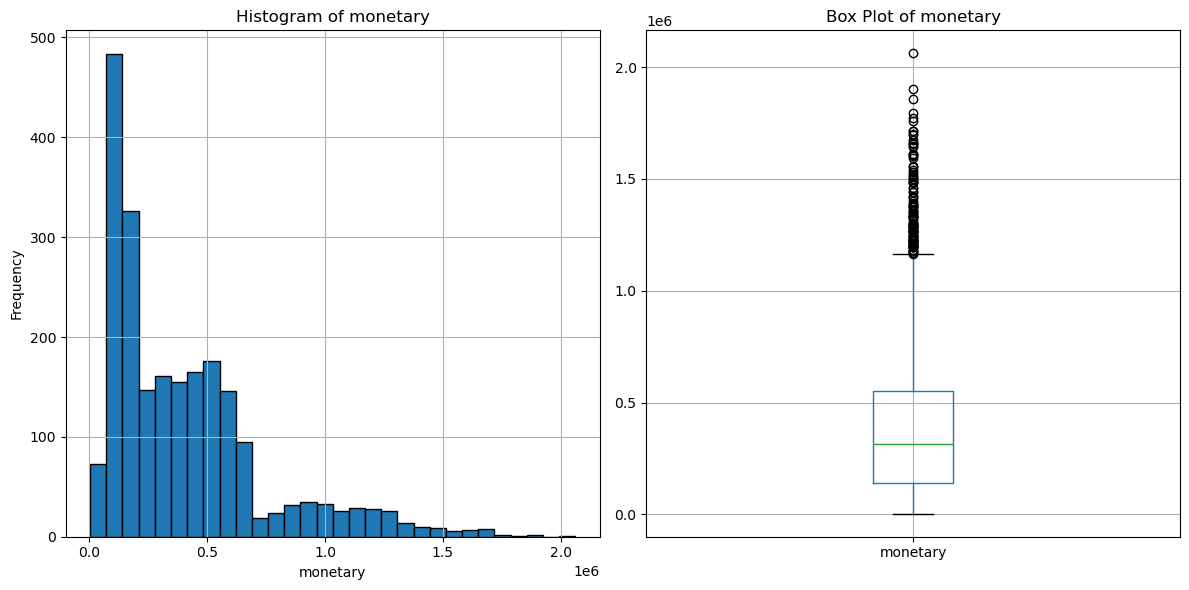

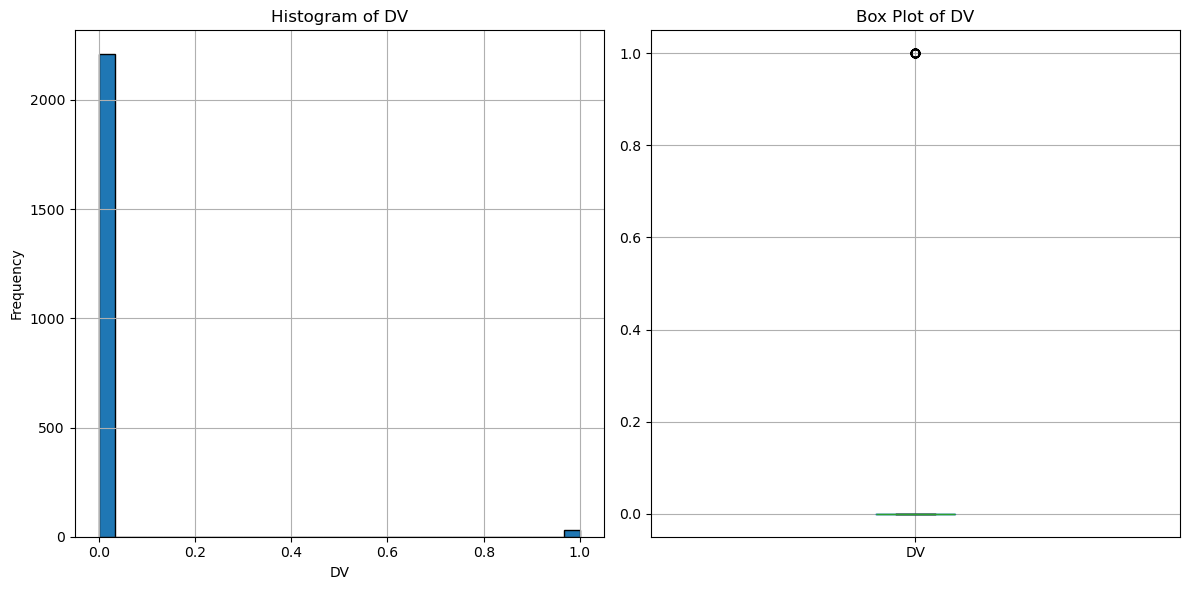

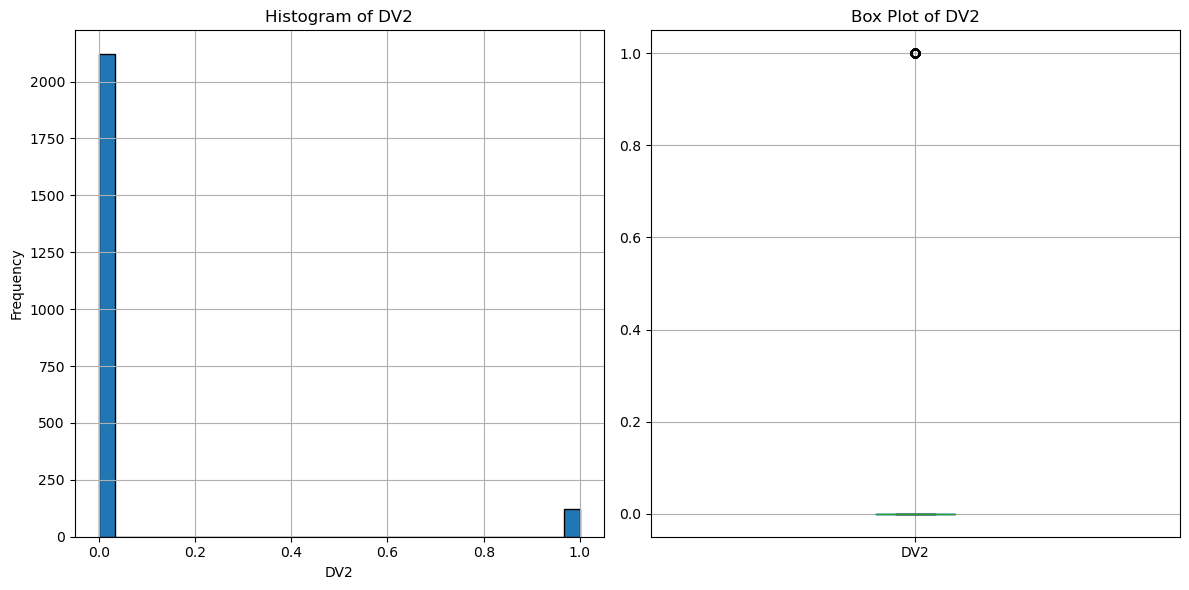

Plotting for Categorical Features...


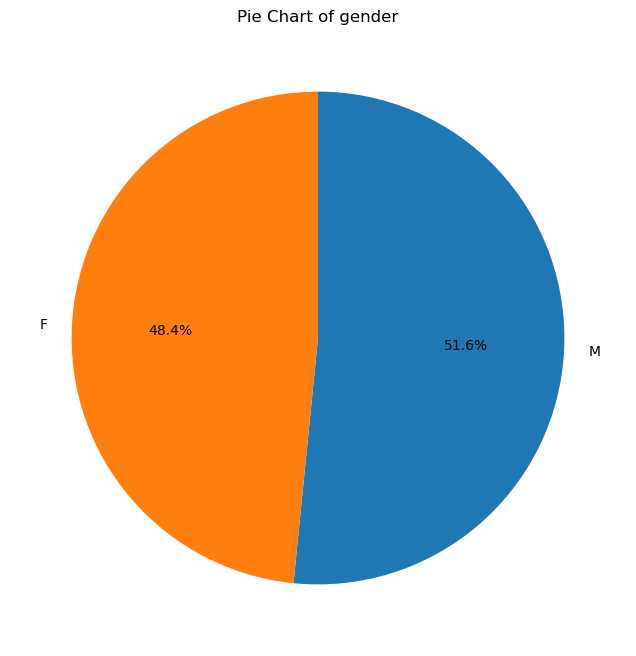

Plotting for Features in 'others'...


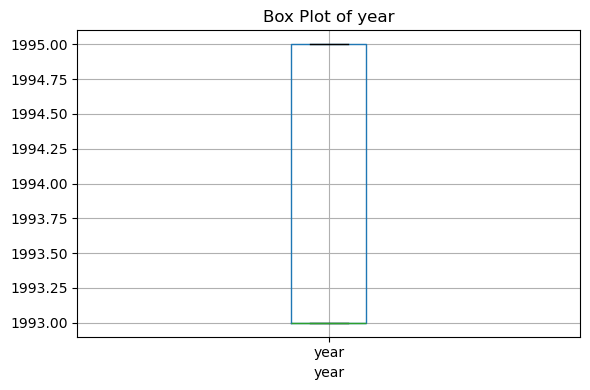

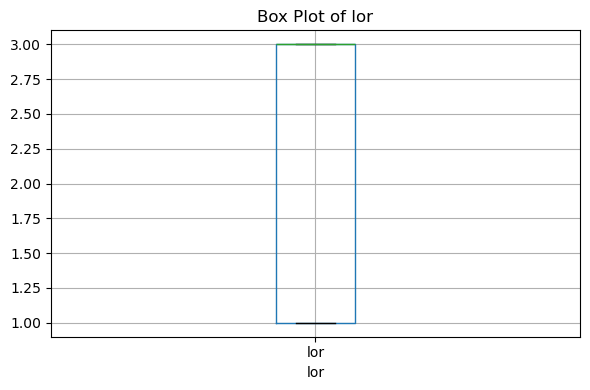

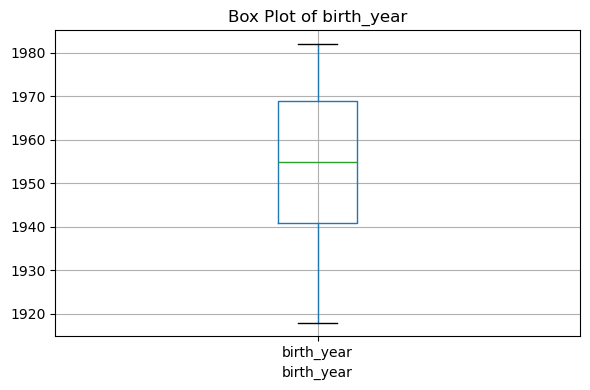

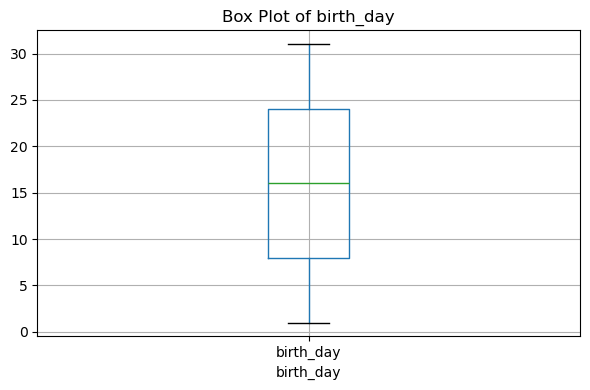

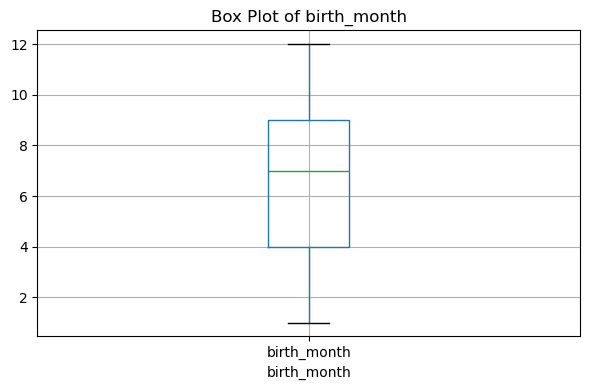

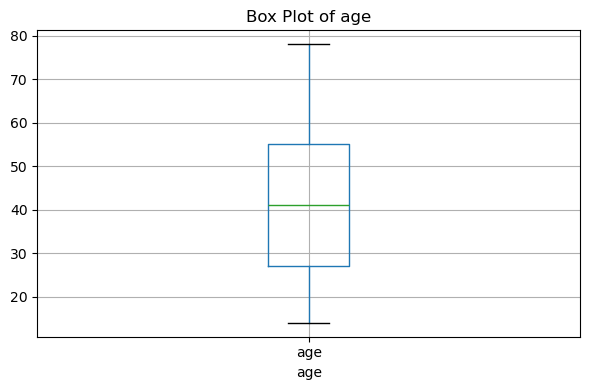

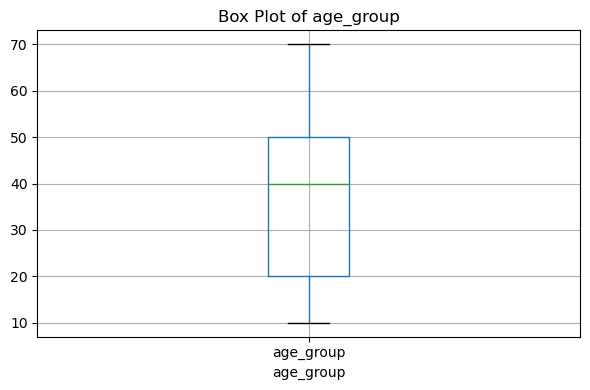

In [172]:
import matplotlib.pyplot as plt

# Numerical Data: Histogram and Box Plot
print("Plotting for Numerical Features...")
for col in categorized_features['numerical']:
    plt.figure(figsize=(12, 6))
    
    # Histogram
    plt.subplot(1, 2, 1)
    df[col].hist(bins=30, edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    
    # Box Plot
    plt.subplot(1, 2, 2)
    df.boxplot(column=col)
    plt.title(f'Box Plot of {col}')
    
    plt.tight_layout()
    plt.show()

# Categorical Data: Pie Chart
print("Plotting for Categorical Features...")
for col in categorized_features['categorical']:
    plt.figure(figsize=(8, 8))
    data_counts = df[col].value_counts()
    
    # Pie Chart
    data_counts.plot.pie(autopct='%1.1f%%', startangle=90, counterclock=False)
    plt.title(f'Pie Chart of {col}')
    plt.ylabel('')  # Remove default ylabel
    plt.show()

# Others Data: Box Plot
print("Plotting for Features in 'others'...")
for col in categorized_features['others']:
    plt.figure(figsize=(6, 4))
    
    # Box Plot
    df.boxplot(column=col)
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    
    plt.tight_layout()
    plt.show()